In [ ]:
import cv2
import numpy as np
import os
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

from keras import models, optimizers, callbacks
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, ReLU
from keras.regularizers import l2

IMG_WIDTH = 32
IMG_HEIGHT = 32
NUM_CATEGORIES = 43

In [ ]:
# retrieving the labeled training images dataset
!wget -q https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip -q GTSRB_Final_Training_Images.zip

In [ ]:
# retrieving unlabeled testing images dataset
!wget -q https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
!unzip -q GTSRB_Final_Test_Images.zip

In [ ]:
# retrieving the csv file that has the labels for test images
!wget -q https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip
!unzip -q GTSRB_Final_Test_GT.zip

In [ ]:
# reading the .ppm files in training dataset using cv2 and resizing them
data_dir = 'GTSRB/Final_Training/Images'

train_images = []
train_labels= []

# iterating through subdirectories 0 to 42
for class_dir in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_dir)

    if not os.path.isdir(class_path):
        continue

    class_label = int(class_dir) # converting directory name to an integer label

    for image_filename in os.listdir(class_path):
        image_path = os.path.join(class_path, image_filename)
        image = cv2.imread(image_path)
        if image is not None:
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
            train_images.append(image)
            train_labels.append(class_label)

print(f"{len(train_labels)} training images and respective labels successfully loaded")

39209 training images and respective labels successfully loaded


In [ ]:
X_train = np.array(train_images, dtype=float)
y_train = np.array(train_labels, dtype=float)

# splitting 10% of training data into validation data
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

In [ ]:
# reading the csv file and creating a dictionary mapping of test image filenames and their labels
df = pd.read_csv('GT-final_test.csv', sep=';')
mapping_df = df[['Filename', 'ClassId']]

label_dict = mapping_df.set_index('Filename')['ClassId'].to_dict()

In [ ]:
# reading the .ppm files in test dataset using cv2 and resizing them
test_dir = 'GTSRB/Final_Test/Images'

test_images = []
test_labels = []

for image_filename in os.listdir(test_dir):
    if not image_filename.endswith(".ppm"):
        continue

    image_path = os.path.join(test_dir, image_filename)
    image = cv2.imread(image_path)
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    test_images.append(image)

    label = label_dict[image_filename]
    test_labels.append(label)

print(f"{len(test_labels)} test images and respective labels successfully loaded")

X_test = np.array(test_images, dtype=float)
y_test = np.array(test_labels, dtype=float)

12630 test images and respective labels successfully loaded


In [ ]:
# normalizing the images
X_train /= 255.0
X_val /= 255.0
X_test /= 255.0

# one-hot encoding integer labels
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
y_test = keras.utils.to_categorical(y_test)

In [ ]:
def build_model():
    layers = [
        Conv2D(32, (3,3), padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        BatchNormalization(),
        ReLU(),
        Conv2D(32, (3,3), padding='same'),
        BatchNormalization(),
        ReLU(),

        MaxPooling2D((2,2)),

        Conv2D(64, (3,3), padding='same'),
        BatchNormalization(),
        ReLU(),
        Conv2D(64, (3,3), padding='same'),
        BatchNormalization(),
        ReLU(),

        MaxPooling2D((2,2)),

        Conv2D(128, (3,3), padding='same'),
        BatchNormalization(),
        ReLU(),
        Conv2D(128, (3,3), padding='same'),
        BatchNormalization(),
        ReLU(),

        MaxPooling2D((2, 2)),
        Flatten(),

        Dense(32),
        BatchNormalization(),
        ReLU(),
        Dropout(0.4),

        Dense(NUM_CATEGORIES, activation='softmax')
    ]

    model = keras.models.Sequential(layers)
    model.compile(optimizer=optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# defining callbacks for model checkpointing and learning rate scheduler
checkpoint_callback = callbacks.ModelCheckpoint(filepath='best_model_weights.h5',
                                                monitor='val_loss',
                                                save_best_only=True,
                                                save_weights_only=True,
                                                verbose=0)

def lr_schedule(epoch, current_lr):
    if epoch in [10, 20]:
        return 0.5 * current_lr
    else:
        return current_lr

lr_scheduler = callbacks.LearningRateScheduler(lr_schedule, verbose=0)

In [ ]:
model = build_model()

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=64, verbose=2, callbacks=[lr_scheduler, checkpoint_callback])

Epoch 1/30
552/552 - 18s - loss: 1.3789 - accuracy: 0.6884 - val_loss: 0.1825 - val_accuracy: 0.9788 - lr: 0.0010 - 18s/epoch - 32ms/step
Epoch 2/30
552/552 - 7s - loss: 0.2892 - accuracy: 0.9394 - val_loss: 0.0306 - val_accuracy: 0.9962 - lr: 0.0010 - 7s/epoch - 13ms/step
Epoch 3/30
552/552 - 5s - loss: 0.1594 - accuracy: 0.9627 - val_loss: 0.0135 - val_accuracy: 0.9982 - lr: 0.0010 - 5s/epoch - 10ms/step
Epoch 4/30
552/552 - 6s - loss: 0.1157 - accuracy: 0.9698 - val_loss: 0.0117 - val_accuracy: 0.9972 - lr: 0.0010 - 6s/epoch - 11ms/step
Epoch 5/30
552/552 - 6s - loss: 0.0921 - accuracy: 0.9749 - val_loss: 0.0066 - val_accuracy: 0.9987 - lr: 0.0010 - 6s/epoch - 10ms/step
Epoch 6/30
552/552 - 5s - loss: 0.0847 - accuracy: 0.9749 - val_loss: 0.0045 - val_accuracy: 0.9985 - lr: 0.0010 - 5s/epoch - 10ms/step
Epoch 7/30
552/552 - 6s - loss: 0.0708 - accuracy: 0.9784 - val_loss: 0.0080 - val_accuracy: 0.9990 - lr: 0.0010 - 6s/epoch - 11ms/step
Epoch 8/30
552/552 - 5s - loss: 0.0644 - accur

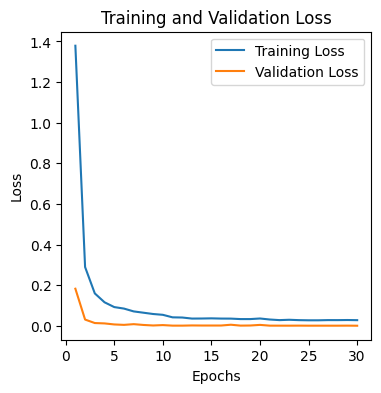

In [ ]:
# plotting training loss and validation loss
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = list(range(1, len(training_loss) + 1))

plt.figure(figsize=(4, 4))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# loading the model with best weights and evaluating it on test data
model.load_weights('best_model_weights.h5')
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)

print(f"The model has achieved a test accuracy of {100 * accuracy:.2f}%")

395/395 - 2s - loss: 0.0297 - accuracy: 0.9924 - 2s/epoch - 4ms/step
The model has achieved a test accuracy of 99.24%


In [ ]:
# function takes integer labels and integer predictions as input and returns a dictionary containing class-wise accuracy
def calc_accuracy(int_predictions, int_labels):
    # converting numpy arrays to lists
    int_predictions = int_predictions.tolist()
    int_labels = int_labels.tolist()

    # dictionary to store class-wise accuracy
    accuracy_dict = {}

    # iterating through each of the 43 classes
    for i in range(43):
        correct = 0
        # counting total number of labels belonging to that particular class
        count = int_labels.count(i)
        if count == 0:
            continue

        for pred, label in zip(int_predictions, int_labels):
            if pred == i and pred == label:
                correct += 1

        class_accuracy = correct/count

        accuracy_dict[str(i)] = class_accuracy

    return accuracy_dict

In [ ]:
y_pred = model.predict(X_test)

# convert one-hot encoded labels and predictions back to integer format
y_test_int = np.argmax(y_test, axis=1)
y_pred_int = np.argmax(y_pred, axis=1)

# calling the calc_accuracy function to calculate the class-wise accuracy scores
accuracy_dict = calc_accuracy(y_pred_int, y_test_int)

for key, value in accuracy_dict.items():
    print(key, "-", value)

395/395 [==============================] - 3s 3ms/step
0 - 1.0
1 - 1.0
2 - 0.9973333333333333
3 - 0.9755555555555555
4 - 0.9939393939393939
5 - 0.9936507936507937
6 - 0.92
7 - 0.9977777777777778
8 - 0.9733333333333334
9 - 1.0
10 - 0.996969696969697
11 - 0.9928571428571429
12 - 0.9898550724637681
13 - 0.9972222222222222
14 - 1.0
15 - 1.0
16 - 0.9933333333333333
17 - 1.0
18 - 0.9923076923076923
19 - 1.0
20 - 1.0
21 - 0.9666666666666667
22 - 0.9833333333333333
23 - 1.0
24 - 0.9777777777777777
25 - 0.9854166666666667
26 - 0.9944444444444445
27 - 1.0
28 - 1.0
29 - 1.0
30 - 0.9133333333333333
31 - 1.0
32 - 1.0
33 - 1.0
34 - 1.0
35 - 1.0
36 - 1.0
37 - 1.0
38 - 0.9985507246376811
39 - 1.0
40 - 0.9777777777777777
41 - 0.9833333333333333
42 - 1.0
